In [1]:
import airfoils as af
import matplotlib.pyplot as plt
import numpy as np
import potential as pot
from wing import Wing

# Airfoil

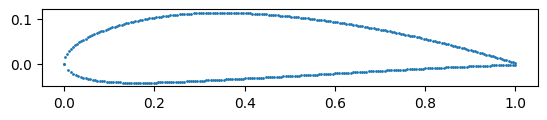

In [2]:
airfoil = af.Airfoil.NACA4("4415", n_points=200)
af_xs, af_ys = airfoil.all_points
plt.scatter(af_xs, af_ys, 1)
plt.axis('scaled')

alpha0 = -4 * np.pi / 180

# Wing Geometry

In [3]:
def linSpan(sp, Ni):
    return np.linspace(0, sp, Ni)

def uniformChord(Ni, ch=1):
    return ch * np.ones(Ni)

In [4]:
N = 50
M = 3
wg = Wing(
    airfoil=airfoil,
    isSymmetric=False,
    span=6/2,
    alpha=2,
    beta=0,
    Ni=N,
    Nj=M,
    sweepOffset=0,
    dihAngle=0,
    chordFun=uniformChord,
    spanFun=linSpan
)
# %matplotlib qt
# wg.plotgrid()

## Wind

In [5]:
Umag = 20
dens = 1.225

# Symmetric Wing

In [6]:
def symm_wing(x, y, z, i, j, panel):

    U1, U1st = pot.hshoeSL2(x, y, z, i, j, panel)
    U2 , U2st = pot.hshoeSL2(x, -y, z, i, j, panel)

    U_ind = np.array([U1[0] + U2[0],
                      U1[1] - U2[1],
                      U1[2] + U2[2]])
    U_ind_st = np.array([U1st[0] + U2st[0],
                         U1st[1] - U2st[1],
                         U1st[2] + U2st[2]])
    return U_ind , U_ind_st

In [7]:
L_sym, D_sym, Gammas, w_ind = wg.solveWingHS(alpha0, Umag, dens, symm_wing)
print(f"For the whole Wing\nL:{2*L_sym}\t|\tD:{2*D_sym}")
print(f"CL:{2*L_sym/(dens*(Umag**2)*wg.wingArea)}\t|\tCD_ind:{2*D_sym/(dens*(Umag**2)*wg.wingArea)}")


For the whole Wing
L:702.6823316894338	|	D:18.373996921416197
CL:0.4780151916254651	|	CD_ind:0.012499317633616459


In [8]:
L_pan = np.zeros((wg.N-1))
D_pan = np.zeros((wg.N-1))
for i in np.arange(0, wg.N-1):
    L_pan[i] = dens * Umag * Gammas[i] * \
        (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1])
    D_pan[i] = - dens * w_ind[i] * Gammas[i] * \
        (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1])

L = np.sum(L_pan)
D = np.sum(D_pan)


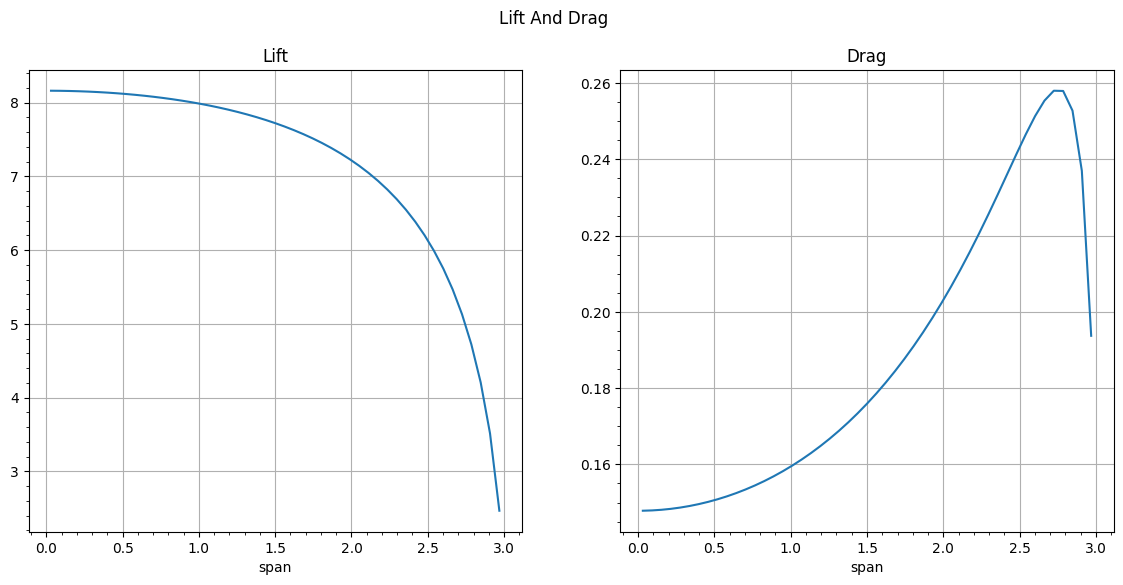

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Lift And Drag')

ax1.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, L_pan)
ax1.set_xlabel("span")
ax1.set_title("Lift")
ax1.minorticks_on()
ax1.grid()

ax2.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, D_pan)
ax2.set_xlabel("span")
ax2.set_title("Drag")
ax2.minorticks_on()
ax2.grid()


/tmp/ipykernel_660630/379557793.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


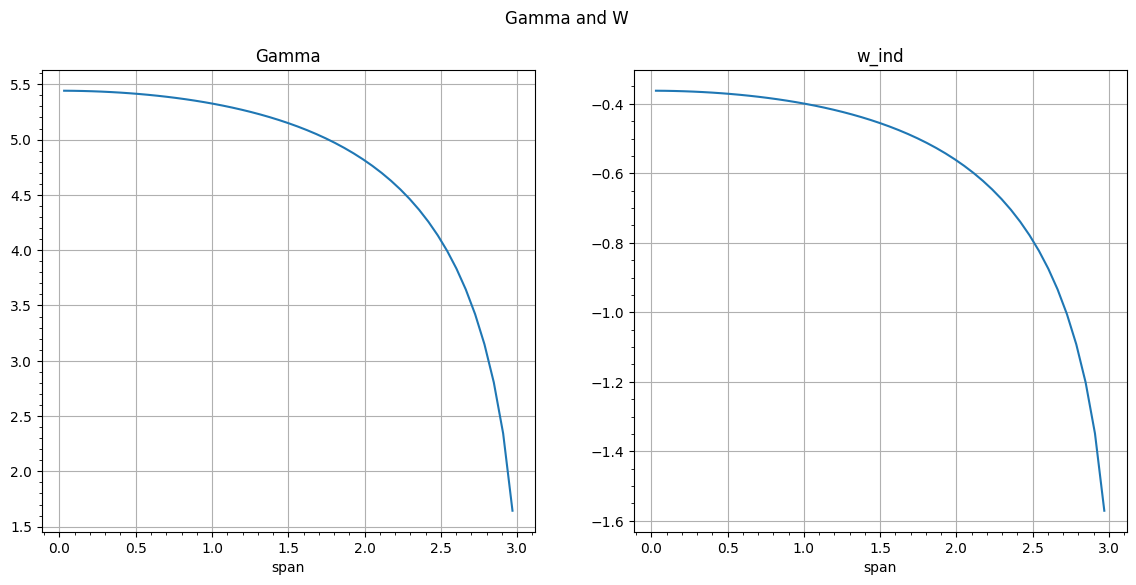

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Gamma and W')

ax1.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, Gammas)
ax1.set_xlabel("span")
ax1.set_title("Gamma")
ax1.minorticks_on()
ax1.grid()

# (w_ind/Umag) * 180 / np.pi)
ax2.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, w_ind)
ax2.set_xlabel("span")
ax2.set_title("w_ind")
ax2.minorticks_on()
ax2.grid()
fig.show()


# Grid Independence

In [11]:
LvsSweep = []
DvsSweep = []
GammavsSweep = []
WindvsSweep = []
Νss = np.linspace(5, 400, 100)
for ni in Νss:
    wg = Wing(
        airfoil=airfoil,
        isSymmetric=False,
        span=6/2,
        alpha=5,
        beta=0,
        Ni=int(ni),
        Nj=M,
        sweepOffset=1,
        dihAngle=0,
        chordFun=uniformChord,
        spanFun=linSpan
    )    
    L, D, Gamma, w = wg.solveWingHS(alpha0, Umag, dens, symm_wing)
    LvsSweep.append(L)
    DvsSweep.append(D)
    GammavsSweep.append(Gamma)
    WindvsSweep.append(w)

LvsSweep = np.array(LvsSweep)
DvsSweep = np.array(DvsSweep)
GammavsSweep = np.array(GammavsSweep)
WindvsSweep = np.array(WindvsSweep)


/tmp/ipykernel_660630/3579984937.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  GammavsSweep = np.array(GammavsSweep)
/tmp/ipykernel_660630/3579984937.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  WindvsSweep = np.array(WindvsSweep)


/tmp/ipykernel_660630/3440270930.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


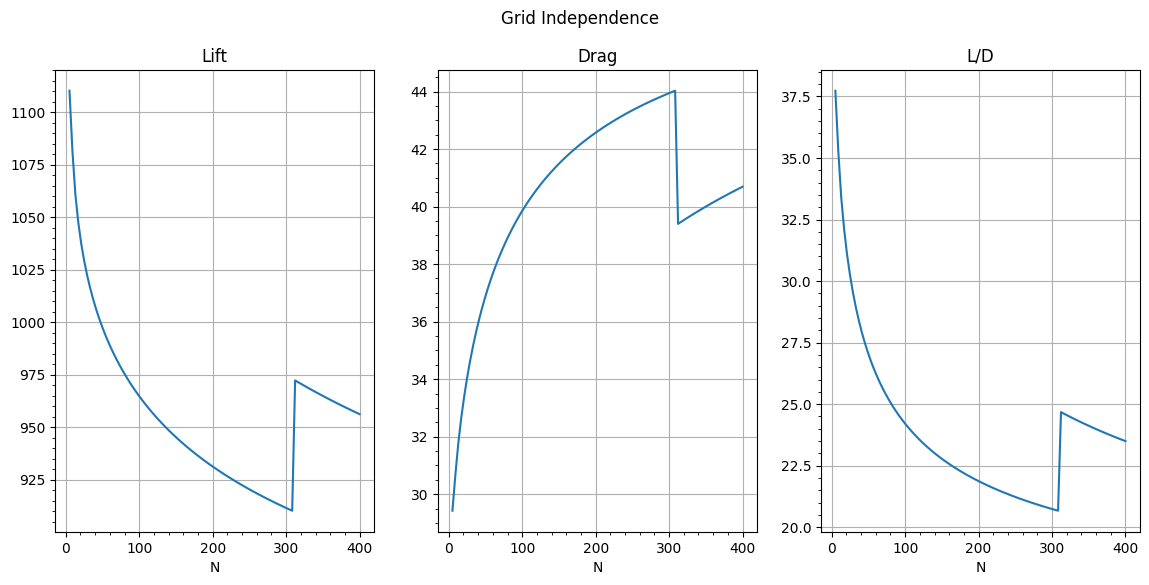

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Grid Independence')

ax1.plot(Νss, 2 * LvsSweep)
ax1.set_xlabel("N")
ax1.set_title("Lift")
ax1.minorticks_on()
ax1.grid()

ax2.plot(Νss, 2*DvsSweep)
ax2.set_xlabel("N")
ax2.set_title("Drag")
ax2.minorticks_on()
ax2.grid()

ax3.plot(Νss, LvsSweep / DvsSweep)
ax3.set_xlabel("N")
ax3.set_title("L/D")
ax3.minorticks_on()
ax3.grid()

fig.show()


# Sweep Effect

In [13]:
LvsSweep = []
DvsSweep = []
GammavsSweep = []
WindvsSweep = []
offsets = np.linspace(0, 3,20)
for offset in offsets:
    wg.set_offset(offset)
    L , D , Gamma , w = wg.solveWingHS(alpha0,Umag,dens,symm_wing)
    LvsSweep.append(L)
    DvsSweep.append(D)
    GammavsSweep.append(Gamma)
    WindvsSweep.append(w)
    
LvsSweep = np.array(LvsSweep)
DvsSweep = np.array(DvsSweep)
GammavsSweep = np.array(GammavsSweep)
WindvsSweep = np.array(WindvsSweep)


/tmp/ipykernel_592338/2246425225.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


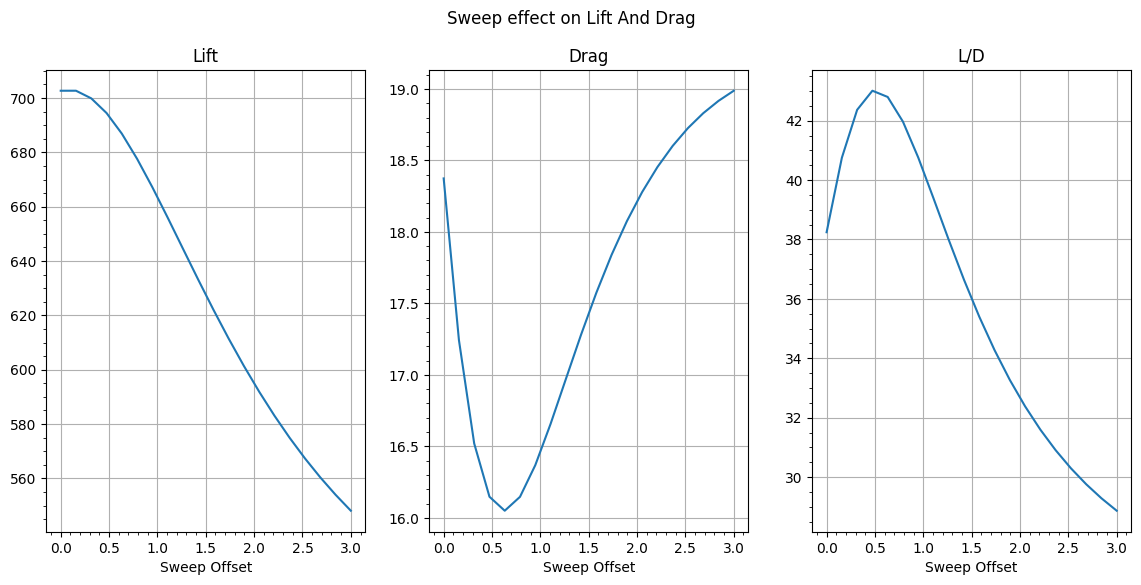

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Sweep effect on Lift And Drag')

ax1.plot(offsets, 2* LvsSweep)
ax1.set_xlabel("Sweep Offset")
ax1.set_title("Lift")
ax1.minorticks_on()
ax1.grid()

ax2.plot(offsets, 2*DvsSweep)
ax2.set_xlabel("Sweep Offset")
ax2.set_title("Drag")
ax2.minorticks_on()
ax2.grid()

ax3.plot(offsets, LvsSweep / DvsSweep)
ax3.set_xlabel("Sweep Offset")
ax3.set_title("L/D")
ax3.minorticks_on()
ax3.grid()

fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_592338/884127247.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


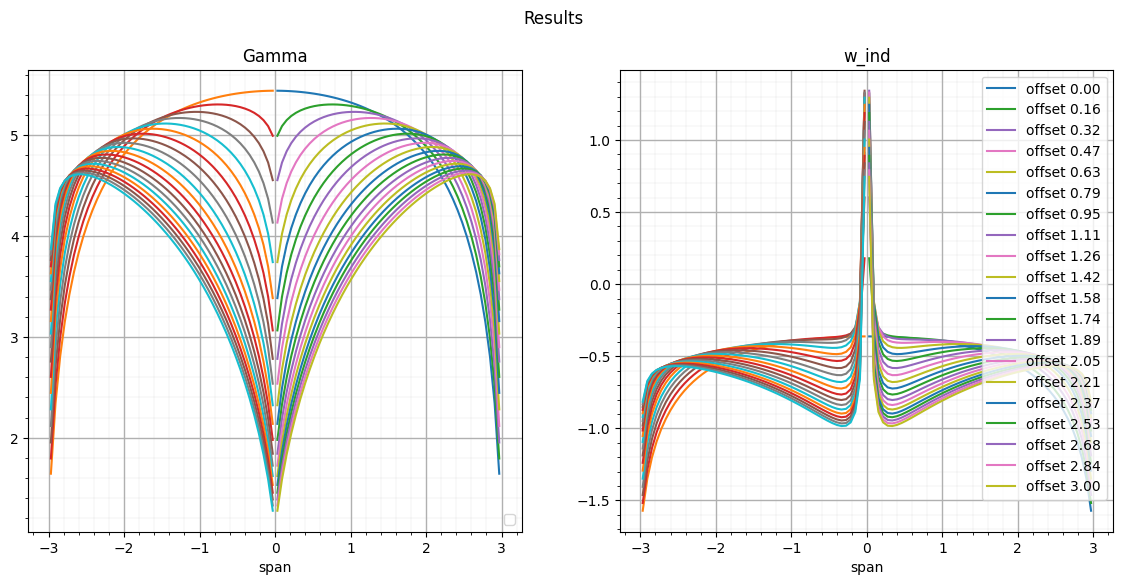

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Results')
for i, offset in enumerate(offsets):
    ax1.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, GammavsSweep[i])#, label="offset {:.2f}".format(offset))
    ax1.plot(-(wg.Dspan[1:] + wg.Dspan[:-1])/2, GammavsSweep[i])

    ax1.set_xlabel("span")
    ax1.set_title("Gamma")

    # (w_ind/Umag) * 180 / np.pi)
    ax2.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, WindvsSweep[i], label="offset {:.2f}".format(offset))
    ax2.plot(-(wg.Dspan[1:] + wg.Dspan[:-1])/2, WindvsSweep[i] )

    ax2.set_xlabel("span")
    ax2.set_title("w_ind")
ax1.legend(loc="lower right")
ax1.grid(which='minor', linewidth=0.1)
ax1.grid(which='major', linewidth=1)
ax1.minorticks_on()

ax2.legend(loc="upper right")
ax2.grid(which='minor', linewidth = 0.1)
ax2.grid(which='major', linewidth = 1)
ax2.minorticks_on()
fig.show()

# ΑΟΑ

In [ ]:
LvsAOA = []
DvsAOA = []
GammavsAOA = []
WindvsAOA = []
angles = np.arange(-5, 15)
wg.set_offset(0)

for angle in angles:
    wg = Wing(
        airfoil=airfoil,
        isSymmetric=False,
        span=6/2,
        alpha=angle,
        beta=0,
        Ni=N,
        Nj=M,
        sweepOffset=0,
        dihAngle=0,
        chordFun=uniformChord,
        spanFun=linSpan
    )
    L, D, Gamma, w = wg.solveWingHS(alpha0, Umag, dens, symm_wing)
    LvsAOA.append(L)
    DvsAOA.append(D)
    GammavsAOA.append(Gamma)
    WindvsAOA.append(w)
    
LvsAOA = np.array(LvsAOA)
DvsAOA = np.array(DvsAOA)
GammavsAOA = np.array(GammavsAOA)
WindvsAOA = np.array(WindvsAOA)


/tmp/ipykernel_592338/3833369974.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


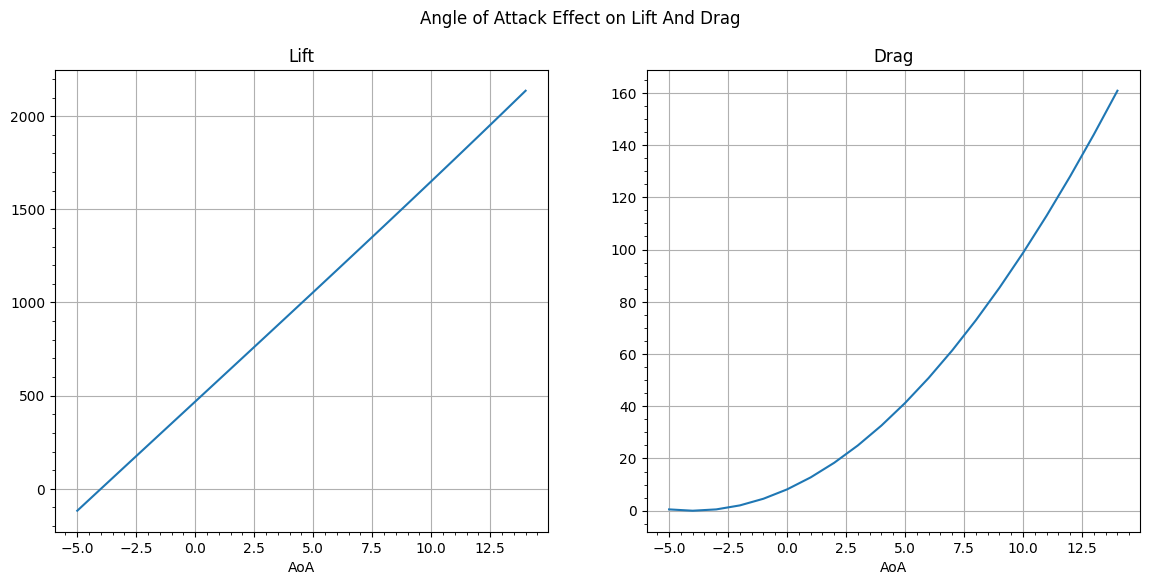

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Angle of Attack Effect on Lift And Drag')

ax1.plot(angles, 2*LvsAOA)
ax1.set_xlabel("AoA")
ax1.set_title("Lift")
ax1.minorticks_on()
ax1.grid()

ax2.plot(angles, 2*DvsAOA)
ax2.set_xlabel("AoA")
ax2.set_title("Drag")
ax2.minorticks_on()
ax2.grid()
fig.show()